In [1]:
import importlib

import settings
import VPINN_tri_final
import mesh_lib

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights
import os 

importlib.reload(settings)
importlib.reload(mesh_lib)
importlib.reload(VPINN_tri_final)

from settings import *
from mesh_lib import *
from VPINN_tri_final import *
tf.config.run_functions_eagerly(True)


os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

settings_lib imported 


2023-11-16 00:16:06.960706: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-16 00:16:06.962031: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 00:16:06.998466: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 00:16:06.999341: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 00:16:07.611840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

interpolator_lib imported
mesh_lib imported
settings_lib imported 
mesh_lib imported


degree =  2  , local dof =  6  internal dof =  0  points inside each edge =  1
[[0 0]
 [1 0]
 [0 1]
 [1/2 0]
 [1/2 1/2]
 [0 1/2]]


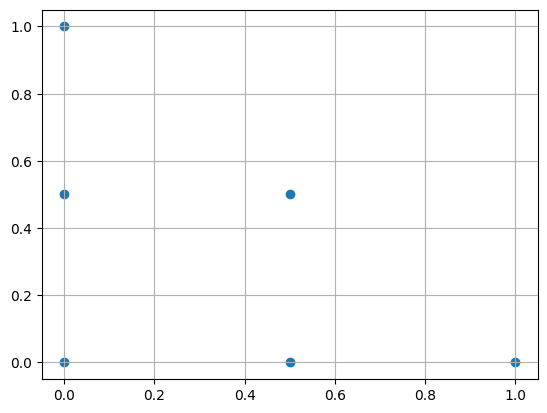

In [2]:
basis=interpolator(2,False,False,points=None)

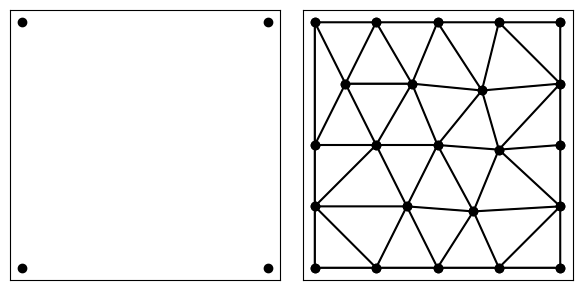

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import triangle as tr

# Step 1: Generate a fine mesh
A = dict(vertices=np.array(((0, 0), (1, 0), (1, 1), (0, 1))))
B = tr.triangulate(A, 'qnea0.05')
tr.compare(plt,A,B)

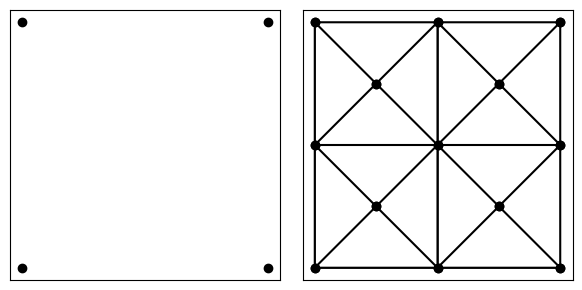

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import triangle as tr



# Step 1: Generate a fine mesh
A = dict(vertices=np.array(((0, 0), (1, 0), (1, 1), (0, 1))))
B = tr.triangulate(A,'qnea0.1')

tr.compare(plt, A, B)

[[ 4 12]
 [ 9 12]
 [ 4  9]
 [ 4  8]
 [ 4  5]
 [ 5  8]
 [ 7 10]
 [ 3  7]
 [ 3 10]
 [ 3  5]
 [ 5 10]
 [ 4  6]
 [ 6 12]
 [ 6  8]
 [ 0  6]
 [ 0  8]
 [ 2 11]
 [ 2  7]
 [ 7 11]
 [ 0  5]
 [ 2  9]
 [ 9 11]
 [ 4  7]
 [ 4 10]
 [ 4 11]
 [ 1  9]
 [ 1 12]
 [ 1  6]]


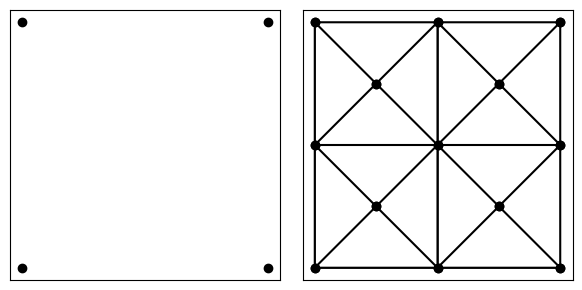

In [5]:

#edges flipping 

for i in range(len(B['edges'])):
    ii=B['edges'][i][0]
    jj=B['edges'][i][1]

    if ii>jj:
            B['edges'][i][0],B['edges'][i][1]=B['edges'][i][1],B['edges'][i][0]

tr.compare(plt, A, B)

print(B['edges'])

In [6]:

#util functions

def get_triangle_edges(triangle_vertices,edges):
    triangle_edges = []
 

    keep=np.zeros((3,),dtype=np.int64)

    for i in range(3):
        ii=triangle_vertices[i].copy()
        jj=triangle_vertices[(i + 1) % 3].copy()
        

        if(ii>jj):
            edge=np.array([jj,ii])
        else:
            edge=np.array([ii,jj])

        index= np.where(np.all(edges == edge, axis=1))[0][0]
        
        triangle_edges.append(index)

        if ii>jj:
            keep[i]=1

    triangle_edges=np.array(triangle_edges)
        
    return keep,triangle_edges

In [7]:
#flipping part + edges
l=[]
temp=[]
for triangle in B['triangles']:
    keep,t=get_triangle_edges(triangle,B['edges'])
    l.append(keep)
    temp.append(t)



keep=np.asarray(l)
edges_index_inside_triangle=np.asarray(temp)

In [8]:
B['keep']=keep
B['edges_index_inside_triangle']=edges_index_inside_triangle

In [9]:
B.keys()

dict_keys(['vertices', 'vertex_markers', 'triangles', 'neighbors', 'edges', 'edge_markers', 'keep', 'edges_index_inside_triangle'])

In [10]:
#exp
n_vertices=len(B['vertices'])
n_traingles=len(B['triangles'])
n_edges=len(B['edges'])

n_inside_edge=basis.n_inside_edge
n_inside=basis.n_inside

vertices_contribution=np.zeros((n_vertices,1))
edges_contribution=np.zeros((n_edges,n_inside_edge))
inside_contribution=np.zeros((n_traingles,n_inside))




for index,triangle in enumerate(B['triangles']):


    if (B['vertex_markers'][triangle[0]]==0):
            vertices_contribution[triangle[0]]=1
    else:
          vertices_contribution[triangle[0]]=2

    if (B['vertex_markers'][triangle[1]]==0):
            vertices_contribution[triangle[1]]=1
    else:
          vertices_contribution[triangle[1]]=2    

    if (B['vertex_markers'][triangle[2]]==0):
            vertices_contribution[triangle[2]]=1
    else:
          vertices_contribution[triangle[2]]=2
    

    if(B['edge_markers'][B['edges_index_inside_triangle'][index][0]]==0):
           
           edges_contribution[B['edges_index_inside_triangle'][index][0]]+=3

    if(B['edge_markers'][B['edges_index_inside_triangle'][index][1]]==0):
           edges_contribution[B['edges_index_inside_triangle'][index][1]]+=3

    if(B['edge_markers'][B['edges_index_inside_triangle'][index][2]]==0):
           edges_contribution[B['edges_index_inside_triangle'][index][2]]+=3      



print(B['edges'])
print(edges_contribution)


    
                                   

[[ 4 12]
 [ 9 12]
 [ 4  9]
 [ 4  8]
 [ 4  5]
 [ 5  8]
 [ 7 10]
 [ 3  7]
 [ 3 10]
 [ 3  5]
 [ 5 10]
 [ 4  6]
 [ 6 12]
 [ 6  8]
 [ 0  6]
 [ 0  8]
 [ 2 11]
 [ 2  7]
 [ 7 11]
 [ 0  5]
 [ 2  9]
 [ 9 11]
 [ 4  7]
 [ 4 10]
 [ 4 11]
 [ 1  9]
 [ 1 12]
 [ 1  6]]
[[6.]
 [6.]
 [6.]
 [6.]
 [6.]
 [6.]
 [6.]
 [0.]
 [6.]
 [0.]
 [6.]
 [6.]
 [6.]
 [6.]
 [0.]
 [6.]
 [6.]
 [0.]
 [6.]
 [0.]
 [0.]
 [6.]
 [6.]
 [6.]
 [6.]
 [0.]
 [6.]
 [0.]]


In [11]:
tfk=tf.keras
tfkl=tf.keras.layers

In [12]:
model = tfk.models.Sequential()
model.add(tf.keras.Input(shape=(2,),dtype=tf.float64))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64))
model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer="glorot_uniform",dtype=tf.float64))

In [13]:
print(model.summary())
print(model.input_shape)
print(model.output_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 371 (2.90 KB)
Trainable params: 371 (2.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
(None, 2)
(None, 1)


In [14]:
from settings import *
N_tests = 2
N_elements = [5, 5]
params = {'scheme': 'VPINNs',
            'NN_struct': [2] + [5] * 3 + [1],
            'var_form': 1,
            'n_elements': tuple(N_elements),
            'n_test': [N_elements[0]*[N_tests], N_elements[1]*[N_tests]],
            'n_quad': 50,
            'n_bound': 80, # for every edge 
            'n_residual': 100,
            'domain': ((0.0, 1.0), (0.0, 1.0)),
            'Opt_Niter': 15000 + 1,
            'delta_test': 0.01,
            'N_test':N_tests}

25
degree =  2  , local dof =  6  internal dof =  0  points inside each edge =  1
[[0 0]
 [1 0]
 [0 1]
 [1/2 0]
 [1/2 1/2]
 [0 1/2]]


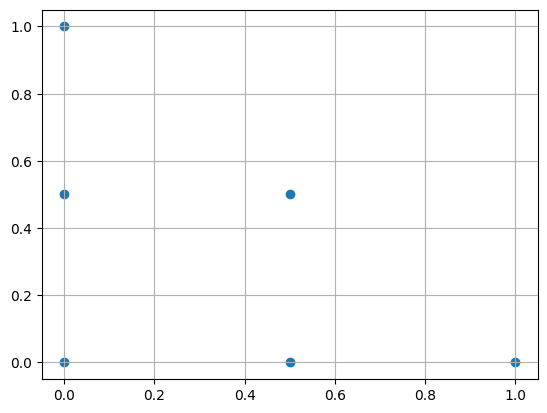

degree =  2  , local dof =  6  internal dof =  0  points inside each edge =  1
[[0 0]
 [1 0]
 [0 1]
 [1/2 0]
 [1/2 1/2]
 [0 1/2]]


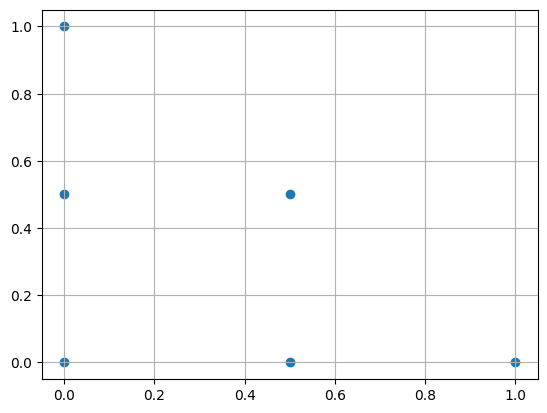

(16,) (16,)


In [15]:
vp=VPINN(pb,params,B,model)

In [16]:
tf.reduce_mean(tf.square(model(vp.boundary_points) - vp.u_bound_exact))

<tf.Tensor: shape=(), dtype=float64, numpy=0.24847666302768084>

In [17]:
_,c,J,B_D,B_DD=vp.b.change_of_coordinates(vp.mesh['vertices'][vp.mesh['triangles'][0]])

t=np.array(vp.grad_test)[0]

print((B_D@t))
print()
xy_quad_element=(B_D@ vp.grad_test)


print(xy_quad_element)

[[-5.01943047 -3.38357491 -1.09997987  0.95955137 -3.05385001 -1.87606661
  -0.23192371  1.25089772 -0.48931642  0.09081072  0.90064717  1.63102336
   1.47626404  1.59831901  1.76870333  1.92236972]
 [ 5.01943047  3.38357491  1.09997987 -0.95955137  3.05385001  1.87606661
   0.23192371 -1.25089772  0.48931642 -0.09081072 -0.90064717 -1.63102336
  -1.47626404 -1.59831901 -1.76870333 -1.92236972]]

tf.Tensor(
[[[ -5.01943047  -3.38357491  -1.09997987   0.95955137  -3.05385001
    -1.87606661  -0.23192371   1.25089772  -0.48931642   0.09081072
     0.90064717   1.63102336   1.47626404   1.59831901   1.76870333
     1.92236972]
  [  5.01943047   3.38357491   1.09997987  -0.95955137   3.05385001
     1.87606661   0.23192371  -1.25089772   0.48931642  -0.09081072
    -0.90064717  -1.63102336  -1.47626404  -1.59831901  -1.76870333
    -1.92236972]]

 [[  0.           0.           0.           0.           0.
     0.           0.           0.           0.           0.
     0.           0.     

In [18]:
print(vp.xy_quad_total)

tf.Tensor(
[[[0.54700955 0.48572395]
  [0.59431582 0.43078925]
  [0.66035365 0.35410239]
  [0.71991193 0.28493997]
  [0.66985833 0.48572395]
  [0.68853508 0.43078925]
  [0.71460716 0.35410239]
  [0.73812107 0.28493997]
  [0.83014167 0.48572395]
  [0.81146492 0.43078925]
  [0.78539284 0.35410239]
  [0.76187893 0.28493997]
  [0.95299045 0.48572395]
  [0.90568418 0.43078925]
  [0.83964635 0.35410239]
  [0.78008807 0.28493997]]

 [[0.2479093  0.2806428 ]
  [0.30665822 0.33176328]
  [0.38866959 0.40312563]
  [0.46263409 0.46748598]
  [0.18648491 0.34206719]
  [0.25954859 0.37887292]
  [0.36154283 0.43025238]
  [0.45352951 0.47659055]
  [0.10634324 0.42220886]
  [0.19808367 0.44033784]
  [0.32614999 0.46564522]
  [0.44165059 0.48846948]
  [0.04491885 0.48363325]
  [0.15097404 0.48744747]
  [0.29902324 0.49277198]
  [0.43254601 0.49757405]]

 [[0.2479093  0.7806428 ]
  [0.30665822 0.83176328]
  [0.38866959 0.90312563]
  [0.46263409 0.96748598]
  [0.18648491 0.84206719]
  [0.25954859 0.8788729

In [19]:
n_triangles=vp.n_triangles
xy_quad_total =vp.xy_quad_total

print(n_triangles)


x_eval=tf.reshape(vp.xy_quad_total,(-1,2))
grad=vp.eval_grad_NN(x_eval)

print(grad)

grad=tf.reshape(grad,(n_triangles,-1,2))

print(tf.shape(grad))

16
tf.Tensor(
[[-0.4336369   0.58619103]
 [-0.38854513  0.5717484 ]
 [-0.32044502  0.54573047]
 [-0.25950007  0.52015494]
 [-0.36715356  0.54257042]
 [-0.33561037  0.53508875]
 [-0.29049821  0.52351986]
 [-0.25013792  0.51277381]
 [-0.28201859  0.48187674]
 [-0.27057281  0.48710272]
 [-0.25389461  0.49529242]
 [-0.23827951  0.50328705]
 [-0.22580937  0.4378154 ]
 [-0.22676308  0.45235585]
 [-0.22813298  0.47456042]
 [-0.22947381  0.49613544]
 [-0.49989284  0.69366058]
 [-0.49409241  0.67292753]
 [-0.48238215  0.64192937]
 [-0.46876022  0.61350545]
 [-0.51515325  0.6878598 ]
 [-0.5132662   0.67181416]
 [-0.49829423  0.64383145]
 [-0.4751542   0.61483097]
 [-0.49948329  0.65896989]
 [-0.51811367  0.65778064]
 [-0.51332322  0.64244243]
 [-0.48298759  0.61618231]
 [-0.46366182  0.62375276]
 [-0.50637614  0.6380329 ]
 [-0.52007284  0.63830026]
 [-0.48857934  0.61691777]
 [-0.49337113  0.53244107]
 [-0.49977825  0.5232044 ]
 [-0.50206861  0.5114747 ]
 [-0.49844114  0.50204751]
 [-0.45654759 

In [20]:
grad_elem=tf.transpose(grad[0])
print(grad_elem)

print(grad_elem @vp.w_quad)

tf.Tensor(
[[-0.4336369  -0.38854513 -0.32044502 -0.25950007 -0.36715356 -0.33561037
  -0.29049821 -0.25013792 -0.28201859 -0.27057281 -0.25389461 -0.23827951
  -0.22580937 -0.22676308 -0.22813298 -0.22947381]
 [ 0.58619103  0.5717484   0.54573047  0.52015494  0.54257042  0.53508875
   0.52351986  0.51277381  0.48187674  0.48710272  0.49529242  0.50328705
   0.4378154   0.45235585  0.47456042  0.49613544]], shape=(2, 16), dtype=float64)
tf.Tensor(
[[-0.29854671]
 [ 0.51095534]], shape=(2, 1), dtype=float64)


In [21]:

w_quad = tf.concat([vp.w_quad.T, tf.ones_like(vp.w_quad.T)], axis=0)
print(w_quad)


tf.Tensor(
[[0.04713674 0.07077614 0.0451681  0.01084645 0.08837018 0.13268843
  0.08467945 0.02033452 0.08837018 0.13268843 0.08467945 0.02033452
  0.04713674 0.07077614 0.0451681  0.01084645]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]], shape=(2, 16), dtype=float64)


In [22]:
vp.grad_test

<tf.Tensor: shape=(6, 2, 16), dtype=float64, numpy=
array([[[-2.50971524, -1.69178745, -0.54998993,  0.47977568,
         -1.52692501, -0.93803331, -0.11596185,  0.62544886,
         -0.24465821,  0.04540536,  0.45032358,  0.81551168,
          0.73813202,  0.79915951,  0.88435166,  0.96118486],
        [-2.50971524, -1.69178745, -0.54998993,  0.47977568,
         -1.52692501, -0.93803331, -0.11596185,  0.62544886,
         -0.24465821,  0.04540536,  0.45032358,  0.81551168,
          0.73813202,  0.79915951,  0.88435166,  0.96118486]],

       [[-0.77158322,  0.10737205,  1.33436173,  2.44096054,
         -0.77158322,  0.10737205,  1.33436173,  2.44096054,
         -0.77158322,  0.10737205,  1.33436173,  2.44096054,
         -0.77158322,  0.10737205,  1.33436173,  2.44096054],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.   

In [23]:
vp.variational_loss()



<tf.Tensor: shape=(), dtype=float64, numpy=330.2072001146082>

In [24]:
vp.variational_loss()

<tf.Tensor: shape=(), dtype=float64, numpy=330.2072001146082>

In [25]:
vp.train(1000)

Iteration: 0 loss: 330.455677 time: 0.14144659042358398
Iteration: 100 loss: 239.554146 time: 5.444004058837891
Iteration: 200 loss: 204.626560 time: 4.966029644012451
Iteration: 300 loss: 190.196017 time: 5.109395742416382
Iteration: 400 loss: 185.663623 time: 5.152328729629517
Iteration: 500 loss: 187.274375 time: 4.926790237426758
Iteration: 600 loss: 193.438049 time: 4.932577610015869
Iteration: 700 loss: 202.815532 time: 4.944641828536987
Iteration: 800 loss: 213.685569 time: 5.148026704788208
Iteration: 900 loss: 224.567909 time: 4.94299840927124


[<tf.Tensor: shape=(), dtype=float64, numpy=330.4556767776359>,
 <tf.Tensor: shape=(), dtype=float64, numpy=239.5541455694665>,
 <tf.Tensor: shape=(), dtype=float64, numpy=204.626559724177>,
 <tf.Tensor: shape=(), dtype=float64, numpy=190.1960168627514>,
 <tf.Tensor: shape=(), dtype=float64, numpy=185.66362341261103>,
 <tf.Tensor: shape=(), dtype=float64, numpy=187.2743745909928>,
 <tf.Tensor: shape=(), dtype=float64, numpy=193.43804929522514>,
 <tf.Tensor: shape=(), dtype=float64, numpy=202.81553169975047>,
 <tf.Tensor: shape=(), dtype=float64, numpy=213.6855688219268>,
 <tf.Tensor: shape=(), dtype=float64, numpy=224.56790910808198>]

In [26]:
np.sum(B['ed'])

KeyError: 'ed'